import sys
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from IPython.display import clear_output
from pathlib import Path
import warnings
from datetime import datetime

# ===========================================================
# 🔧 Logger – zapisuje logi i ostrzeżenia, bez spamowania konsoli
# ===========================================================
class TeeLogger:
    def __init__(self, filename, silent=True):
        self.log = open(filename, "a", encoding="utf-8")
        self.silent = silent  # jeśli True – nie drukuje w konsoli

    def write(self, message):
        if not self.silent:
            sys.__stdout__.write(message)
        self.log.write(message)

    def flush(self):
        self.log.flush()
        if not self.silent:
            sys.__stdout__.flush()

# --- inicjalizacja logera ---
log_file = f"simulation_console_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
sys.stdout = TeeLogger(log_file, silent=True)

# --- przekierowanie ostrzeżeń do loga ---
def custom_warn(message, category, filename, lineno, file=None, line=None):
    sys.stdout.write(warnings.formatwarning(message, category, filename, lineno))
warnings.showwarning = custom_warn

print(f"📜 Wszystkie logi i ostrzeżenia zapisywane w: {log_file}\n")

plt.style.use("seaborn-v0_8-darkgrid")

# ===========================================================
# 🔧 KONFIGURACJA ŚCIEŻKI DO PROJEKTU
# ===========================================================
ROOT = Path.cwd()
while ROOT.name != "ETH-volitality-fotecasting" and ROOT.parent != ROOT:
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

try:
    from src.config import LOGS_DIR
except ModuleNotFoundError:
    LOGS_DIR = ROOT / "logs"
    LOGS_DIR.mkdir(exist_ok=True)
    print(f"⚠️ Nie znaleziono src.config — utworzono lokalny LOGS_DIR → {LOGS_DIR}")

print(f"📂 Ścieżka projektu dodana do sys.path:\n{ROOT}")

# ===========================================================
# 🧠 SYMULACJA EGARCH "LIVE"
# ===========================================================
def simulate_egarch_live(
    csv_path="simulation_csv.csv",
    model_filename="egarch_ETH_5m_p1_o1_q1_t.pkl",
    n_obs=3000,
    batch_size=5,
    window_size=600,
    scale_window=400,
    delay=2.0
):
    """Symuluje działanie modelu EGARCH w czasie rzeczywistym — świeczka po świeczce."""
    print(f"📂 Wczytuję model: {model_filename}")
    payload = pickle.load(open(LOGS_DIR / model_filename, "rb"))
    fitted, base_scale = payload["model"], payload["scale"]

    candles = pd.read_csv(csv_path)
    candles["open_time"] = pd.to_datetime(candles["open_time"])
    candles = candles.head(n_obs).reset_index(drop=True)
    print(f"📈 Wczytano {len(candles)} świeczek z pliku {csv_path}")

    model, params, vol = fitted.model, fitted.params, fitted.model.volatility
    returns_memory = list(fitted.model._y[-window_size:])
    prev_close = candles.loc[0, "close"]

    forecasts, realized, timestamps, logs = [], [], [], []
    log_path = Path("simulation_logs.csv")

    print(f"\n🚀 Start symulacji ({n_obs} świeczek, batch={batch_size}, window={window_size}, scale_window={scale_window})")

    for i in range(1, len(candles)):
        row = candles.iloc[i]
        current_close = row["close"]
        log_return = np.log(current_close / prev_close)
        prev_close = current_close
        r_std = log_return / base_scale
        returns_memory.append(r_std)
        if len(returns_memory) > window_size:
            returns_memory.pop(0)

        realized.append(abs(log_return))
        timestamps.append(row["open_time"])

        if i % batch_size == 0:
            subseries = np.array(returns_memory)
            local_window = min(len(subseries), scale_window)
            local_scale = np.std(subseries[-local_window:])
            subseries_std = subseries / local_scale

            temp_model = arch_model(
                subseries_std, vol="EGARCH",
                p=vol.p, o=vol.o, q=vol.q,
                dist="t", mean="constant"
            )
            res = temp_model.fit(disp="off", update_freq=0, starting_values=params)
            params = res.params
            if np.any(np.isnan(params)) or np.any(np.abs(params) > 100):
                print(f"⚠️ Model się rozjechał przy świeczce {i}, pomijam update.")
                continue

            fcast_var = res.forecast(horizon=1, reindex=False).variance.values[-1, 0]
            fcast_sigma = np.sqrt(fcast_var) * local_scale * base_scale

            if len(forecasts) > 0:
                fcast_sigma = 0.9 * forecasts[-1] + 0.1 * fcast_sigma
            fcast_sigma = np.clip(fcast_sigma, 1e-5, 0.05)

            forecasts.append(fcast_sigma)

            logs.append({
                "iteration": i,
                "timestamp": str(row["open_time"]),
                "sigma_pred": float(fcast_sigma),
                "local_scale": float(local_scale),
                "mean_abs_return": float(np.mean(np.abs(subseries[-local_window:]))),
                **{f"param_{k}": float(v) for k, v in params.items()}
            })

            if i % 100 == 0:
                pd.DataFrame(logs).to_csv(log_path, index=False)
                print(f"💾 Logi nadpisane ({len(logs)} wpisów) → {log_path}")

            # --- WIZUALIZACJA ---
            clear_output(wait=True)
            x_real = np.arange(len(realized[-300:]))
            x_pred = np.arange(len(forecasts[-300:])) + 1

            plt.figure(figsize=(12, 5))
            plt.plot(x_real, realized[-300:], color="black", alpha=0.6, label="Rzeczywista σ_t")
            plt.plot(x_pred, forecasts[-300:], color="red", label="Prognozowana σ_{t+1}")
            plt.legend()
            plt.title(f"Symulacja live EGARCH – prognozowana vs rzeczywista zmienność\n"
                      f"aktualna świeczka: {row['open_time']}")
            plt.xlabel("Indeks świeczki (ostatnie 300 obserwacji)")
            plt.ylabel("Zmienność (σ)")
            plt.tight_layout()
            plt.show()

        time.sleep(delay)

    if logs:
        pd.DataFrame(logs).to_csv(log_path, index=False)
        print(f"🧾 Zapisano końcową wersję logów ({len(logs)} wpisów).")

    result = pd.DataFrame({
        "open_time": timestamps[:len(forecasts)],
        "sigma_pred": forecasts,
        "sigma_real": realized[:len(forecasts)]
    })
    result.to_csv("simulation_results.csv", index=False)
    print("💾 Wyniki zapisane do: simulation_results.csv")
    print("\n✅ Symulacja zakończona.")
    return result


In [2]:
import sys
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from IPython.display import clear_output
from pathlib import Path
import warnings
from datetime import datetime
import hashlib

# ===========================================================
# 🔧 Logger – zapisuje logi i ostrzeżenia, bez spamowania konsoli
# ===========================================================
class TeeLogger:
    def __init__(self, filename, silent=True):
        self.log = open(filename, "a", encoding="utf-8")
        self.silent = silent

    def write(self, message):
        if not self.silent:
            sys.__stdout__.write(message)
        self.log.write(message)

    def flush(self):
        self.log.flush()
        if not self.silent:
            sys.__stdout__.flush()

log_file = f"simulation_console_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
sys.stdout = TeeLogger(log_file, silent=True)

def custom_warn(message, category, filename, lineno, file=None, line=None):
    sys.stdout.write(warnings.formatwarning(message, category, filename, lineno))
warnings.showwarning = custom_warn

print(f"📜 Wszystkie logi i ostrzeżenia zapisywane w: {log_file}\n")
plt.style.use("seaborn-v0_8-darkgrid")

# ===========================================================
# 🔧 KONFIGURACJA ŚCIEŻKI DO PROJEKTU
# ===========================================================
ROOT = Path.cwd()
while ROOT.name != "ETH-volitality-fotecasting" and ROOT.parent != ROOT:
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

try:
    from src.config import LOGS_DIR
except ModuleNotFoundError:
    LOGS_DIR = ROOT / "logs"
    LOGS_DIR.mkdir(exist_ok=True)
    print(f"⚠️ Nie znaleziono src.config — utworzono lokalny LOGS_DIR → {LOGS_DIR}")

print(f"📂 Ścieżka projektu dodana do sys.path:\n{ROOT}")

# ===========================================================
# 🔁 Generator strumieniowy świeczek
# ===========================================================
def stream_candles(csv_path, chunk_size=1000, n_obs=None):
    count = 0
    for chunk in pd.read_csv(csv_path, chunksize=chunk_size, parse_dates=["open_time"]):
        for _, row in chunk.iterrows():
            yield row
            count += 1
            if n_obs and count >= n_obs:
                return

# ===========================================================
# 🧠 SYMULACJA EGARCH "LIVE" – wersja ulepszona
# ===========================================================
def simulate_egarch_live_v2(
    csv_path="simulation_csv.csv",
    model_filename="egarch_ETH_5m_p1_o1_q1_t.pkl",
    n_obs=3000,
    batch_size=5,
    window_size=600,
    scale_window=400,
    delay=2.0,
    mode_recursive=True
):
    """Symuluje działanie modelu EGARCH w czasie rzeczywistym — świeczka po świeczce."""
    # --- Meta i identyfikacja runu ---
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    meta_hash = hashlib.md5((csv_path + model_filename + str(np.random.rand())).encode()).hexdigest()[:8]
    run_id = f"EGARCH_SIM_{timestamp}_{meta_hash}"
    log_path = Path(f"simulation_logs_{run_id}.csv")
    result_path = Path(f"simulation_results_{run_id}.csv")
    print(f"🧬 RUN ID: {run_id}")

    # --- Model bazowy ---
    print(f"📂 Wczytuję model: {model_filename}")
    payload = pickle.load(open(LOGS_DIR / model_filename, "rb"))
    fitted, base_scale = payload["model"], payload["scale"]
    model, params, vol = fitted.model, fitted.params, fitted.model.volatility
    prev_params = params.copy()

    returns_memory = list(fitted.model._y[-window_size:])
    forecasts, realized, timestamps, logs = [], [], [], []
    prev_close = None

    print(f"\n🚀 Start symulacji (n={n_obs}, batch={batch_size}, window={window_size}, mode={'recursive' if mode_recursive else 'refit'})")

    for i, row in enumerate(stream_candles(csv_path, n_obs=n_obs)):
        current_close = row["close"]

        if prev_close is None:
            prev_close = current_close
            continue

        log_return = np.log(current_close / prev_close)
        prev_close = current_close
        r_std = log_return / base_scale

        returns_memory.append(r_std)
        if len(returns_memory) > window_size:
            returns_memory.pop(0)

        realized.append(abs(log_return))
        timestamps.append(row["open_time"])

        if i % batch_size == 0 and len(returns_memory) > 5:
            subseries = np.array(returns_memory)
            local_window = min(len(subseries), scale_window)
            local_scale = np.std(subseries[-local_window:])
            subseries_std = subseries / local_scale

            try:
                if mode_recursive:
                    fcast_var = fitted.forecast(horizon=1, reindex=False).variance.values[-1, 0]
                    fcast_sigma = np.sqrt(fcast_var) * local_scale * base_scale
                else:
                    temp_model = arch_model(subseries_std, vol="EGARCH",
                                            p=vol.p, o=vol.o, q=vol.q,
                                            dist="t", mean="constant")
                    res = temp_model.fit(disp="off", update_freq=0, starting_values=params)
                    params = res.params
                    fcast_var = res.forecast(horizon=1, reindex=False).variance.values[-1, 0]
                    fcast_sigma = np.sqrt(fcast_var) * local_scale * base_scale
            except Exception as e:
                print(f"⚠️ Błąd przy batchu {i}: {e}")
                params = prev_params.copy()
                continue

            # --- sanity check ---
            if np.any(np.isnan(params)) or np.any(np.abs(params) > 100):
                print(f"⚠️ Model się rozjechał przy świeczce {i}, przywracam poprzednie parametry.")
                params = prev_params.copy()
                continue
            else:
                prev_params = params.copy()

            # --- smoothing ---
            if forecasts:
                fcast_sigma = 0.9 * forecasts[-1] + 0.1 * fcast_sigma
            fcast_sigma = np.clip(fcast_sigma, 1e-5, 0.05)
            forecasts.append(fcast_sigma)

            # --- monitoring driftu ---
            corr50 = np.corrcoef(forecasts[-50:], realized[-50:])[0, 1] if len(forecasts) > 50 else np.nan

            logs.append({
                "iteration": i,
                "timestamp": str(row["open_time"]),
                "sigma_pred": float(fcast_sigma),
                "local_scale": float(local_scale),
                "corr_rolling50": float(corr50),
                **{f"param_{k}": float(v) for k, v in params.items()}
            })

            if i % 100 == 0:
                pd.DataFrame(logs).to_csv(log_path, index=False)
                print(f"💾 Logi nadpisane ({len(logs)} wpisów) → {log_path}")

            # --- wizualizacja ---
            clear_output(wait=True)
            x_real = np.arange(len(realized[-300:]))
            x_pred = np.arange(len(forecasts[-300:])) + 1
            plt.figure(figsize=(12, 5))
            plt.plot(x_real, realized[-300:], color="black", alpha=0.6, label="Rzeczywista σ_t")
            plt.plot(x_pred, forecasts[-300:], color="red", label="Prognozowana σ_{t+1}")
            plt.legend()
            plt.title(f"EGARCH Live v2 – aktualna świeczka: {row['open_time']}")
            plt.tight_layout()
            plt.show()

        time.sleep(delay)

    if logs:
        pd.DataFrame(logs).to_csv(log_path, index=False)
        print(f"🧾 Zapisano końcową wersję logów ({len(logs)} wpisów).")

    result = pd.DataFrame({
        "open_time": timestamps[:len(forecasts)],
        "sigma_pred": forecasts,
        "sigma_real": realized[:len(forecasts)]
    })
    result.to_csv(result_path, index=False)
    print(f"💾 Wyniki zapisane do: {result_path}")
    print(f"\n✅ Symulacja {run_id} zakończona.")
    return result


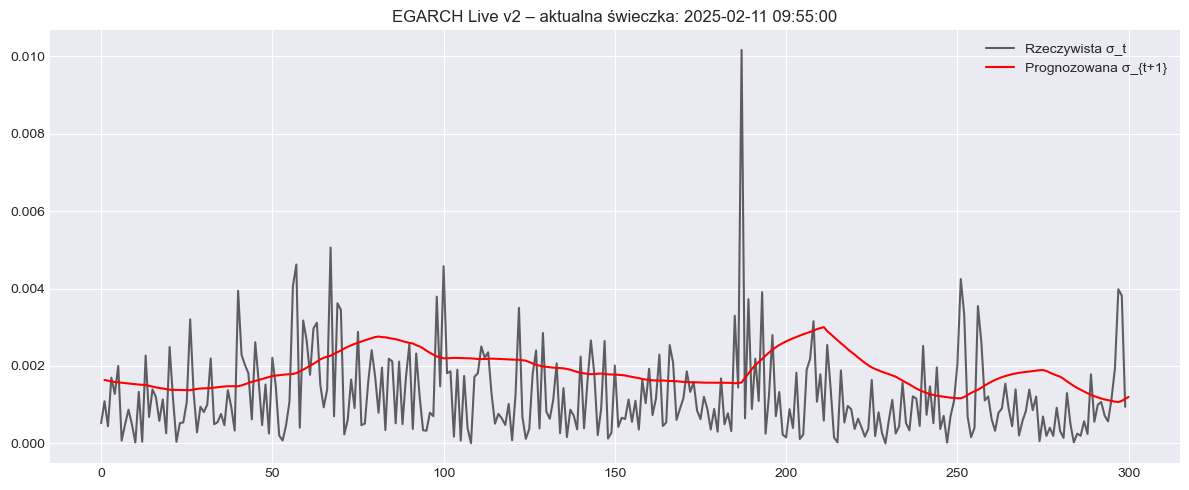

In [3]:
result = simulate_egarch_live_v2(
    csv_path="simulation_csv.csv",
    model_filename="egarch_ETH_5m_p1_o1_q1_t.pkl",
    n_obs=3000,
    batch_size=1,
    window_size=800,
    scale_window=24,
    delay=0.01,
    mode_recursive=True   # 🔹 używa forecastów bez retrainu
)
